In [1]:
# Cell 1: Imports Yada Yada

import os
import glob
import numpy as np
import pandas as pd
import h5py
import uproot
import awkward as ak
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc,
    precision_recall_curve, average_precision_score
)

print("TensorFlow Version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Num GPUs Available: {len(gpus)}")
    for gpu in gpus:
        print(f"  - {gpu.name}")
else:
    print("No GPU detected. TensorFlow will use the CPU.")

2025-07-05 14:19:32.697035: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 14:19:32.736871: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-05 14:19:32.736899: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-05 14:19:32.736905: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-05 14:19:32.748362: I tensorflow/core/platform/cpu_feature_g

TensorFlow Version: 2.14.0
Num GPUs Available: 1
  - /physical_device:GPU:0


In [2]:
# Cell 2: Configurations and Helper Functions
from sklearn.model_selection import train_test_split

# --- 1. Configuration ---
selected_variables = [
    "Jet_pt1",
    "Jet_pt2",
    "jet1_eta",
    "jet2_eta",
    "jet1_phi",
    "jet2_phi",
    "met_pt",
    "jet1_met_dphi",
    "met_significance",
]

signal_file = "/home/sgoswami/mg5-tutorial/flattuple-yy_qcd_600K.root"
background_file = "/home/sgoswami/mg5-tutorial/flattuple-znunu_600K.root"
tree_name = "flat_delphes"


# --- 2. Helper Function ---
def importance_shuffle(X, y):
    idx = np.random.permutation(len(X))
    Xs = X.iloc[idx].reset_index(drop=True)
    ys = y[idx]
    return Xs, ys


# --- 3. Data Loading ---
print("Loading signal file...")
with uproot.open(signal_file) as f:
    sig_df = ak.to_dataframe(f[tree_name].arrays(selected_variables, library="ak"))

print("Loading background file...")
with uproot.open(background_file) as f:
    bkg_df = ak.to_dataframe(f[tree_name].arrays(selected_variables, library="ak"))

print(f"Initial counts: Signal = {len(sig_df)}, Background = {len(bkg_df)}")


# --- 4. Balance Signal and Background (1:1 Ratio) ---
n_samples = min(len(sig_df), len(bkg_df))
print(f"Balancing datasets to {n_samples} events each.")

sig_df_balanced = sig_df.sample(n=n_samples, random_state=42).reset_index(drop=True)
bkg_df_balanced = bkg_df.sample(n=n_samples, random_state=42).reset_index(drop=True)


# --- 5. Combine, Label, and Shuffle ---
X_full_df = pd.concat([sig_df_balanced, bkg_df_balanced], axis=0)
y_full = np.concatenate([
    np.ones(n_samples),  # Signal labels
    np.zeros(n_samples) # Background labels
]).astype(np.int64)

X_full_df, y_full = importance_shuffle(X_full_df, y_full)

print(f"\nCombined dataset shape: {X_full_df.shape}")
print(f"Combined class distribution: {np.bincount(y_full)}")


# --- 6. Final Split into Training and Validation Sets ---
X_train_df, X_val_df, y_train, y_val = train_test_split(
    X_full_df, y_full, test_size=0.2, random_state=42, stratify=y_full
)

print(f"\nTrain set shape: {X_train_df.shape}")
print(f"Validation set shape:  {X_val_df.shape}")

Loading signal file...
Loading background file...
Initial counts: Signal = 600000, Background = 578089
Balancing datasets to 578089 events each.

Combined dataset shape: (1156178, 9)
Combined class distribution: [578089 578089]

Train set shape: (924942, 9)
Validation set shape:  (231236, 9)


Data integrity check:
                     count        mean         std           min        25%  \
Jet_pt1           924942.0  386.742310  351.401245  2.005296e+01  57.470698   
Jet_pt2           924942.0  293.330200  277.957642  2.000029e+01  36.989118   
jet1_eta          924942.0   -0.024965    1.444413 -4.861106e+00  -0.899565   
jet2_eta          924942.0   -0.040689    1.574959 -4.904191e+00  -1.055951   
jet1_phi          924942.0   -0.000795    1.814558 -3.141592e+00  -1.573949   
jet2_phi          924942.0    0.004645    1.813148 -3.141577e+00  -1.563695   
met_pt            924942.0   93.396851   76.810051  1.226300e-01  45.240823   
jet1_met_dphi     924942.0    2.005624    0.877020  2.384186e-07   1.399810   
met_significance  924942.0    3.900975    2.851162  4.869356e-03   1.769272   

                         50%         75%          max  
Jet_pt1           300.076279  666.701233  3044.453857  
Jet_pt2           202.740967  511.428024  2508.614746  
jet1_eta           

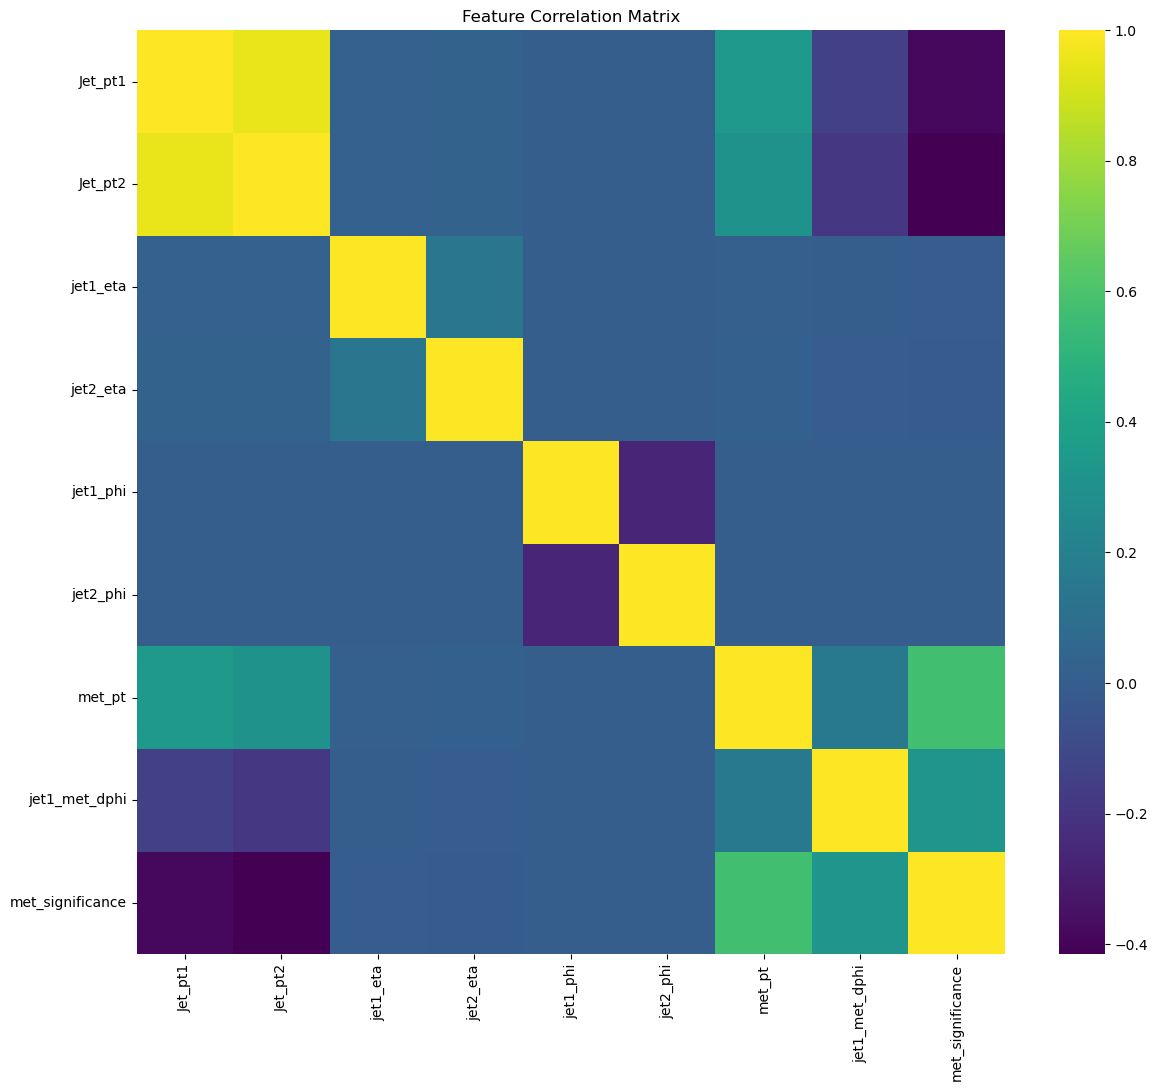

In [3]:
# Cell 3: Data Analysis & Visualization
import seaborn as sns

# Data integrity check
print("Data integrity check:")
print(X_train_df.describe().transpose())
print("\nChecking for NaN values:")
print(X_train_df.isna().sum())

# Feature Correlation Matrix
plt.figure(figsize=(14, 12))
correlation_matrix = X_train_df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='viridis')
plt.title('Feature Correlation Matrix')
plt.show()

In [4]:
# Cell 4: Define Model, Optimizer, and Callbacks

def build_model(input_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(64, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(32, kernel_initializer='he_normal', activation='gelu'),
        BatchNormalization(),
        Dense(1, kernel_initializer='he_normal', activation='sigmoid'),
    ])
    return model

# saving to .keras (old loader causes issues)

lr          = 5e-5
epochs      = 150
batch_size  = 512

metric_list = [
    AUC(name='auc'),
    'accuracy',
    Precision(name='precision'),
    Recall(name='recall')
]

callbacks = [
    EarlyStopping(
        monitor='val_auc',
        patience=20,
        mode='max',
        verbose=1,
        restore_best_weights=True
    ),
    ReduceLROnPlateau(
        monitor='val_auc',
        factor=0.2,
        patience=7,
        mode='max',
        verbose=1,
        min_lr=1e-7
    ),
]

model = build_model(input_dim=X_train_df.shape[1])

model.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',
    metrics=metric_list
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_2 (Bat  (None, 32)                1

2025-07-05 14:20:20.669071: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1029 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [5]:
# Cell 5: Train Model

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df.values)
X_val = scaler.transform(X_val_df.values)

print(f"Starting training with LR={lr}, BS={batch_size}, Epochs={epochs}")
history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    verbose=1
)
model.save("best_model.keras", save_format="keras")

Starting training with LR=5e-05, BS=512, Epochs=150
Epoch 1/150


2025-07-05 14:20:45.223476: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x70b9ec1354e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-05 14:20:45.223503: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-07-05 14:20:45.227281: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-05 14:20:45.242062: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-07-05 14:20:45.315067: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1807/1807 [==============================] - 11s 4ms/step - loss: 0.0686 - auc: 0.9981 - accuracy: 0.9802 - precision: 0.9811 - recall: 0.9792 - val_loss: 0.0140 - val_auc: 0.9998 - val_accuracy: 0.9968 - val_precision: 0.9964 - val_recall: 0.9971 - lr: 5.0000e-05
Epoch 2/150
1807/1807 [==============================] - 7s 4ms/step - loss: 0.0121 - auc: 0.9997 - accuracy: 0.9968 - precision: 0.9964 - recall: 0.9972 - val_loss: 0.0097 - val_auc: 0.9997 - val_accuracy: 0.9973 - val_precision: 0.9967 - val_recall: 0.9980 - lr: 5.0000e-05
Epoch 3/150
1807/1807 [==============================] - 7s 4ms/step - loss: 0.0097 - auc: 0.9997 - accuracy: 0.9972 - precision: 0.9967 - recall: 0.9977 - val_loss: 0.0084 - val_auc: 0.9997 - val_accuracy: 0.9976 - val_precision: 0.9969 - val_recall: 0.9982 - lr: 5.0000e-05
Epoch 4/150
1807/1807 [==============================] - 7s 4ms/step - loss: 0.0087 - auc: 0.9997 - accuracy: 0.9974 - precision: 0.9969 - recall: 0.9979 - val_loss: 0.0076 - val_auc:

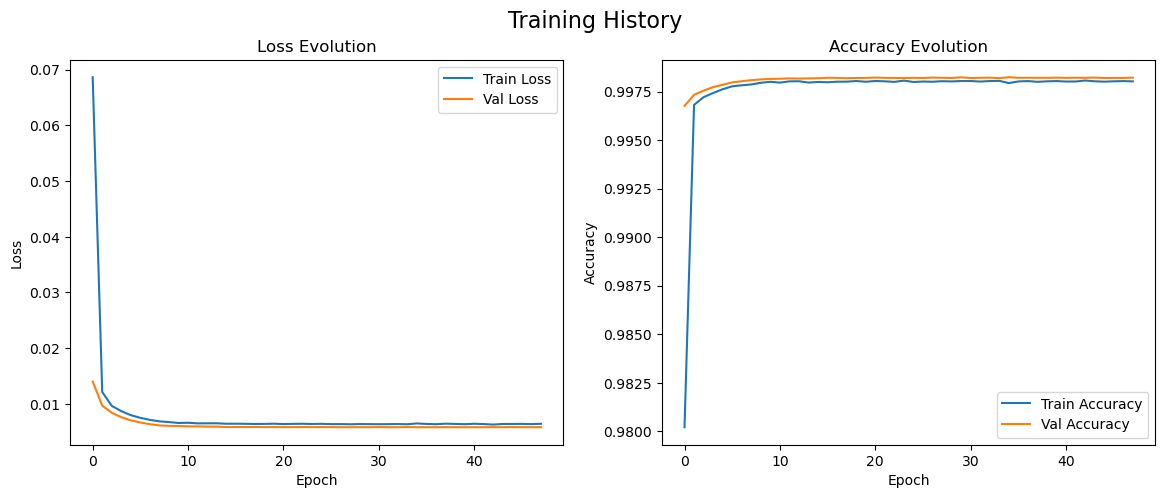

7227/7227 [==============================] - 7s 908us/step


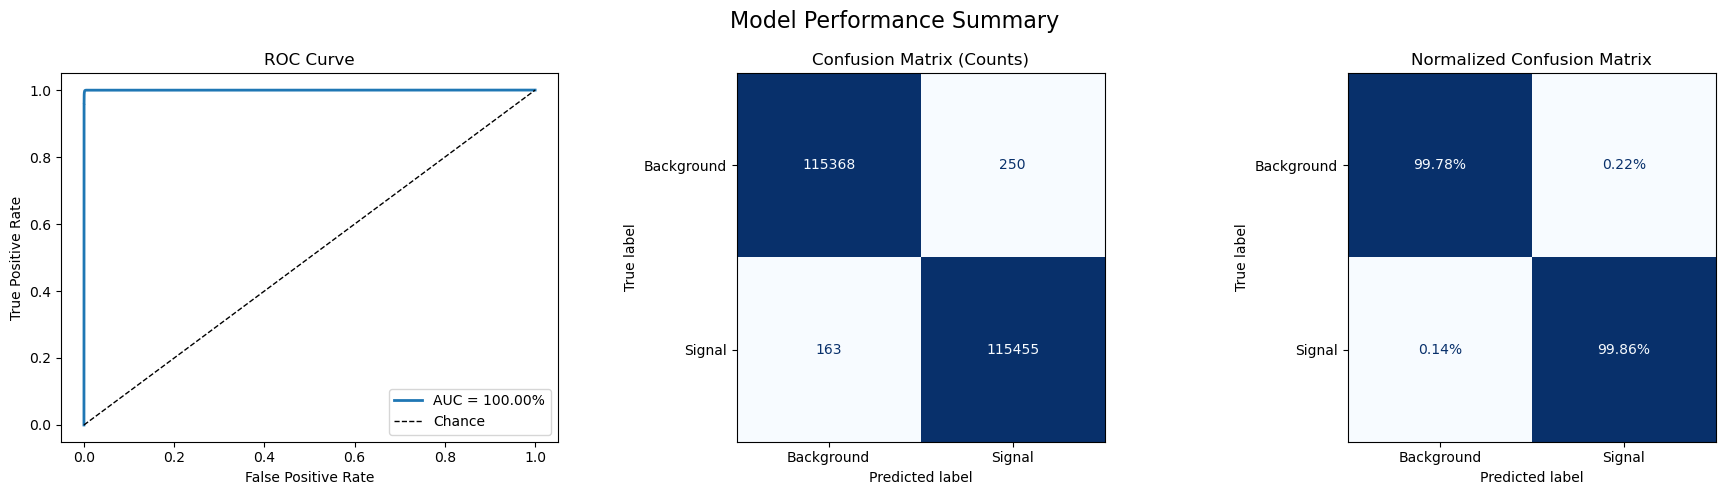

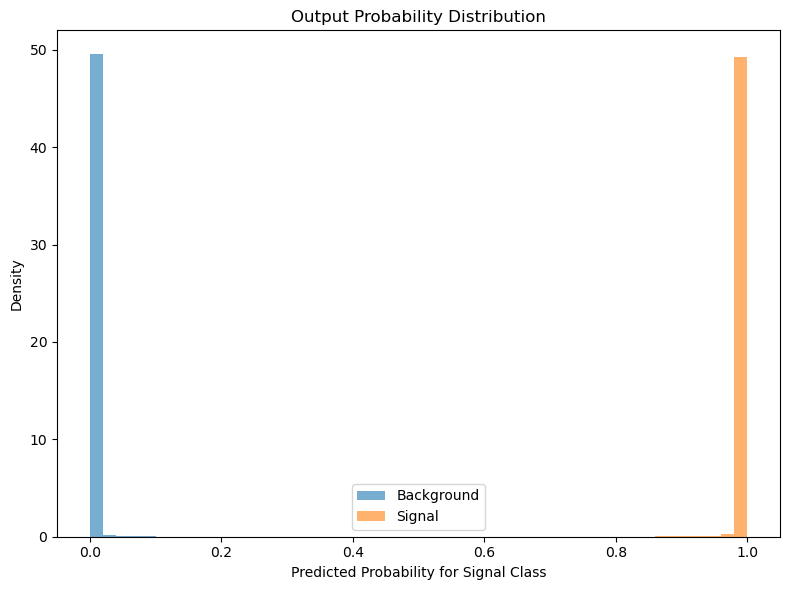

In [6]:
# Cell 6: Evaluate Model and Plot Results
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Plot Loss and Accuracy vs. Epoch
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Training History', fontsize=16)

ax1.plot(history.history['loss'], label='Train Loss')
ax1.plot(history.history['val_loss'], label='Val Loss')
ax1.set_title('Loss Evolution')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history.history['accuracy'], label='Train Accuracy')
ax2.plot(history.history['val_accuracy'], label='Val Accuracy')
ax2.set_title('Accuracy Evolution')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

y_pred_probs = model.predict(X_val).squeeze()
y_pred_class = (y_pred_probs > 0.5).astype(int)

y_pred_class = (y_pred_probs > 0.5).astype(int)
fpr, tpr, _ = roc_curve(y_val, y_pred_probs)
roc_auc = auc(fpr, tpr)
cm = confusion_matrix(y_val, y_pred_class)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Model Performance Summary', fontsize=16)

# Plot 1: ROC Curve
ax1.plot(fpr, tpr, label=f'AUC = {roc_auc*100:.2f}%', lw=2)
ax1.plot([0, 1], [0, 1], 'k--', lw=1, label='Chance')
ax1.set_title('ROC Curve')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.legend(loc='lower right')

# Plot 2: Confusion Matrix (Raw Counts)
disp1 = ConfusionMatrixDisplay(cm, display_labels=['Background', 'Signal'])
disp1.plot(ax=ax2, cmap='Blues', colorbar=False, values_format='d')
ax2.set_title('Confusion Matrix (Counts)')

# Plot 2A: Normalized Confusion Matrix (Percentages)
disp2 = ConfusionMatrixDisplay(cm_norm, display_labels=['Background', 'Signal'])
disp2.plot(ax=ax3, cmap='Blues', colorbar=False, values_format='.2%')
ax3.set_title('Normalized Confusion Matrix')

plt.tight_layout()
plt.show()

# Plot 3: Plot Output Probability Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_probs[y_val==0], bins=50, alpha=0.6, label='Background', density=True)
plt.hist(y_pred_probs[y_val==1], bins=50, alpha=0.6, label='Signal', density=True)
plt.xlabel('Predicted Probability for Signal Class')
plt.ylabel('Density')
plt.title('Output Probability Distribution')
plt.legend()
plt.tight_layout()
plt.show()

--- Calculating and Plotting Feature Importance ---
Baseline Validation AUC: 1.0000


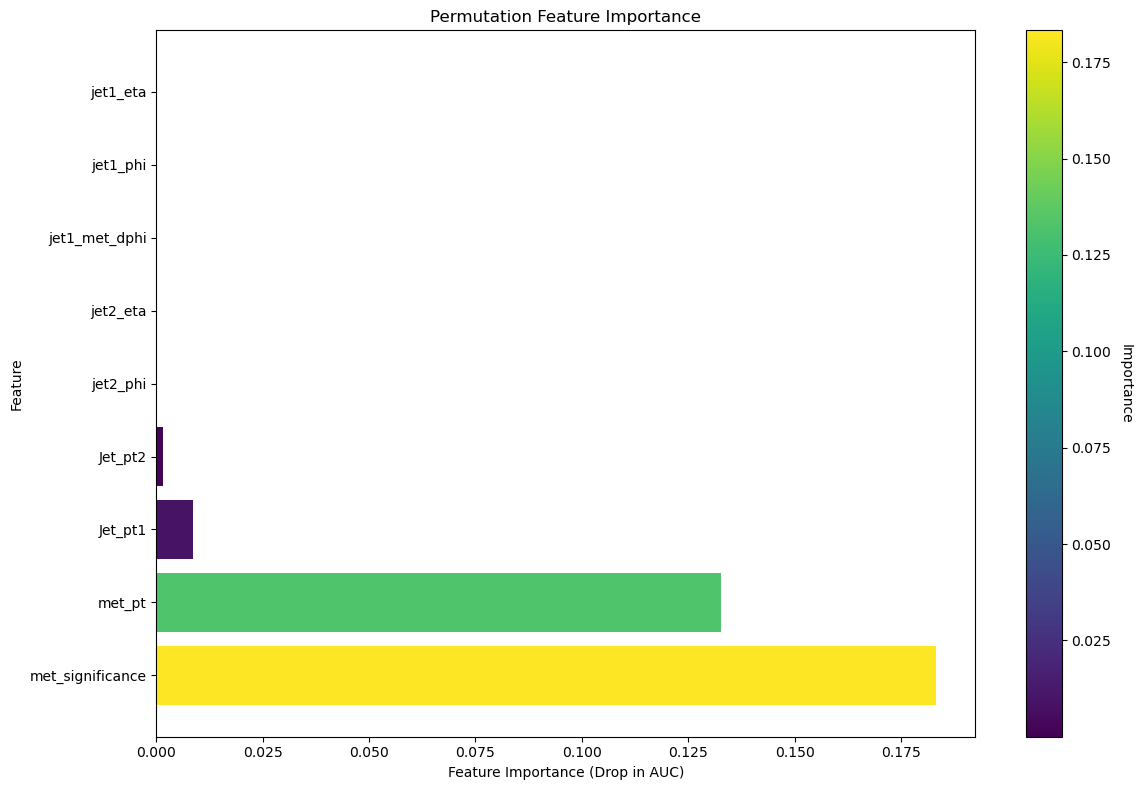

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.metrics import roc_auc_score

print("--- Calculating and Plotting Feature Importance ---")

model = tf.keras.models.load_model('best_model.keras')

y_pred_baseline = model.predict(X_val, batch_size=batch_size, verbose=0).squeeze()
baseline_auc = roc_auc_score(y_val, y_pred_baseline)
print(f"Baseline Validation AUC: {baseline_auc:.4f}")

importances = []

for i in range(X_val.shape[1]):
    X_val_permuted = X_val.copy()
    np.random.shuffle(X_val_permuted[:, i])

    y_pred_permuted = model.predict(X_val_permuted, batch_size=batch_size, verbose=0).squeeze()
    permuted_auc = roc_auc_score(y_val, y_pred_permuted)

    feature_importance = baseline_auc - permuted_auc
    importances.append(feature_importance)


importance_df = pd.DataFrame({
    'feature': selected_variables,
    'importance': importances
}).sort_values(by='importance', ascending=True)


import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))

cmap = plt.get_cmap('viridis')
norm = plt.Normalize(
    vmin=importance_df['importance'].min(),
    vmax=importance_df['importance'].max()
)


ax.barh(
    importance_df['feature'],
    importance_df['importance'],
    color=cmap(norm(importance_df['importance']))
)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=ax)
cbar.set_label('Importance', rotation=270, labelpad=15)

ax.set_xlabel("Feature Importance (Drop in AUC)")
ax.set_ylabel("Feature")
ax.set_title("Permutation Feature Importance")
ax.invert_yaxis()

fig.tight_layout()
plt.show()